In [62]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
import pmdarima as pm


from sklearn.metrics import mean_squared_error as mse

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [63]:
passengers = pd.read_excel("projek_time_series.xlsx",
                          index_col = "date",
                          parse_dates = ["date"])
passengers.index

DatetimeIndex(['2006-01-01', '2006-02-01', '2006-03-01', '2006-04-01',
               '2006-05-01', '2006-06-01', '2006-07-01', '2006-08-01',
               '2006-09-01', '2006-10-01',
               ...
               '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
               '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01',
               '2023-10-01', '2023-11-01'],
              dtype='datetime64[ns]', name='date', length=215, freq=None)

In [64]:
startDate = '2020-01-01'
endDate = '2022-06-01'


passengers["covid"] = pd.Series(passengers.index, index=passengers.index).apply(lambda x: 1 if pd.to_datetime(startDate) <= x <= pd.to_datetime(endDate) else 0)


In [65]:
passengers

,sumatera,jabodetabek,jawa_nonjabodetabek,covid
date,,,,
2006-01-01,324,8681,2823,0
2006-02-01,226,8144,3561,0
2006-03-01,248,8920,4146,0
2006-04-01,252,8462,4195,0
2006-05-01,263,8899,4413,0
...,...,...,...,...
2023-07-01,576,25211,7161,0
2023-08-01,581,24979,5763,0
2023-09-01,451,25082,5985,0


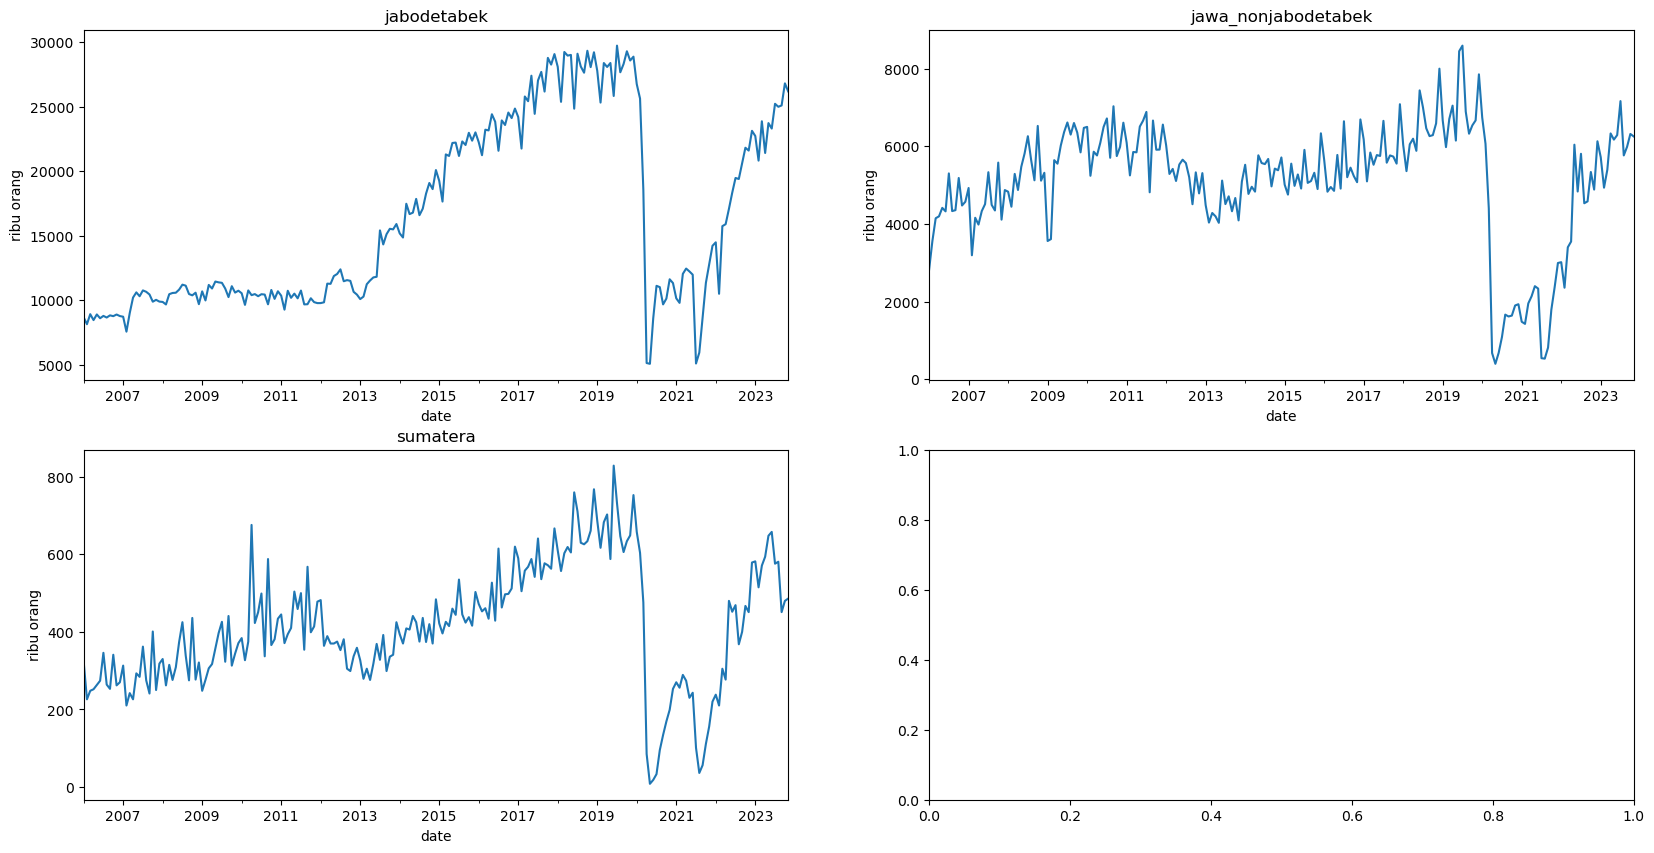

In [66]:
origin_plot = ['jabodetabek', 'jawa_nonjabodetabek', 'sumatera']

fig, axes = plt.subplots(2, 2,
                         figsize=(20, 10))
    
for c, ax in zip(origin_plot, axes.ravel()):
    passengers[f"{c}"].plot(ax = ax,
                                          title = f"{c}",
                                          ylabel = "ribu orang")

plt.show()

melihat adanya penurunan signifikan semasa covid menyebabkan jumlah penumpang turun. Maka untuk data testing akan dipilih hanya 12 bulan terakhir dari Desember 2022 sampai November 2023

# Test Train Split

In [67]:
split = '2022-12-01'

train = passengers[:'2022-11-01']
test = passengers[split:]

# infer frequency for modeling
train = train.asfreq(pd.infer_freq(train.index))
test = test.asfreq(pd.infer_freq(test.index))
passengers = passengers.asfreq(pd.infer_freq(passengers.index))

In [68]:
train

,sumatera,jabodetabek,jawa_nonjabodetabek,covid
date,,,,
2006-01-01,324,8681,2823,0
2006-02-01,226,8144,3561,0
2006-03-01,248,8920,4146,0
2006-04-01,252,8462,4195,0
2006-05-01,263,8899,4413,0
...,...,...,...,...
2022-07-01,469,19467,5805,0
2022-08-01,368,19388,4532,0
2022-09-01,400,20587,4580,0


In [69]:
test

,sumatera,jabodetabek,jawa_nonjabodetabek,covid
date,,,,
2022-12-01,579,23118,6127,0
2023-01-01,582,22717,5718,0
2023-02-01,515,20811,4933,0
2023-03-01,571,23856,5393,0
2023-04-01,594,21402,6329,0
2023-05-01,648,23716,6170,0
2023-06-01,658,23292,6287,0
2023-07-01,576,25211,7161,0
2023-08-01,581,24979,5763,0


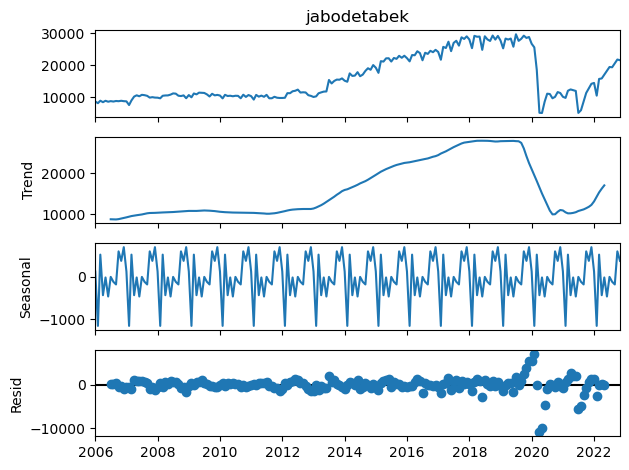

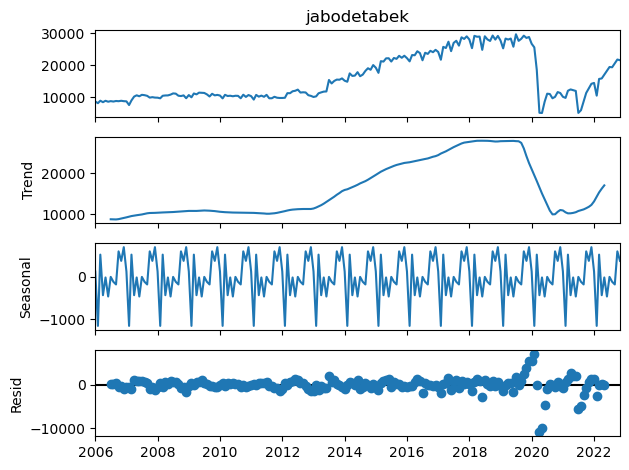

In [70]:
res = seasonal_decompose(train["jabodetabek"],
                         period = 12)
res.plot()

Dari seasonal decompose dapat kita lihat adanya tren naik sebelum covid kemudian turun semasa covid dan ada tren naik kembali pasca covid. Selain itu kita lihat adanya seasonality untuk ketiga data. Terakhir ada data outlier ketika masa-masa covid. Untuk sementara kita biarkan untuk melihat oerdorma model ketika ada data anomali yang terjadi.

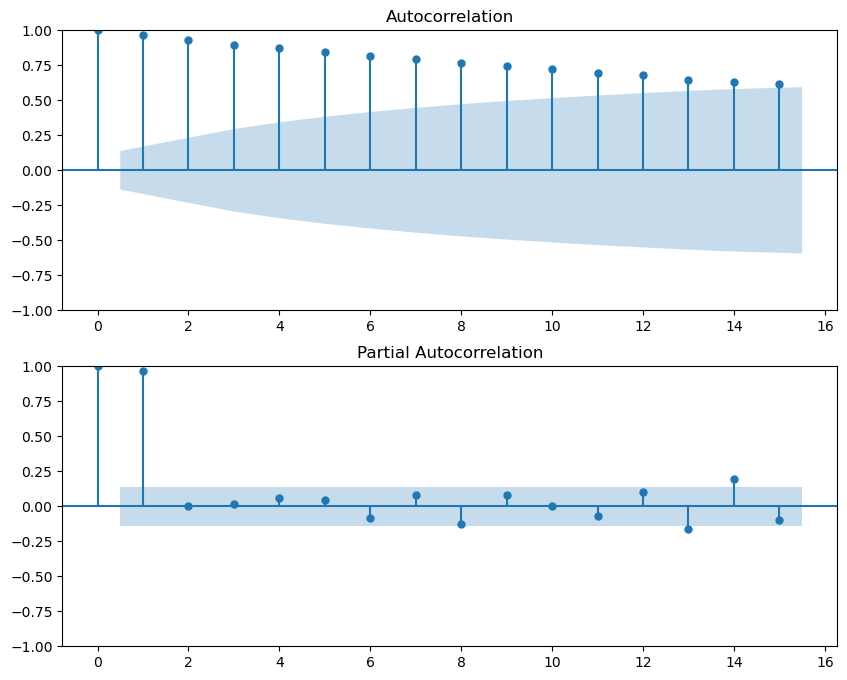

In [71]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train["jabodetabek"], lags=15, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train["jabodetabek"], lags=15, ax=ax2)

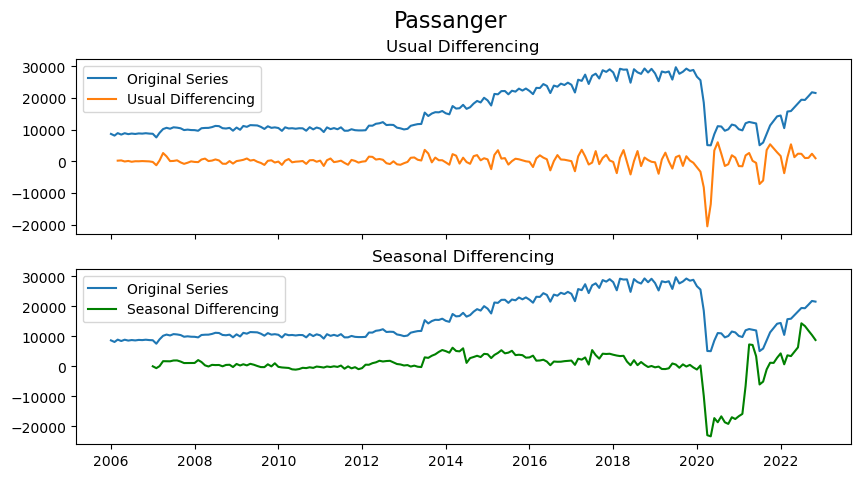

In [72]:

fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(train.jabodetabek, label='Original Series')
axes[0].plot(train.jabodetabek.diff(2), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Differencing
axes[1].plot(train.jabodetabek, label='Original Series')
axes[1].plot(train.jabodetabek.diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Passanger', fontsize=16)
plt.show()

Dapat dilihat penurunan drastis membuat data menjadi tidak stationer bahkan setelah dilakukan diffrencing.


# Modelling

In [73]:
# coba default model
fit1 = pm.auto_arima(train.jabodetabek, m=12, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=3607.151, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=3603.546, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=3599.547, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=3599.920, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=3601.805, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=3605.261, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=3601.546, Time=0.40 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=3601.546, Time=0.23 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=3599.798, Time=0.14 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=2.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=3597.596, Time=0.28 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=3599.596, Time=0.85 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=3599.783, Time=0.20 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=3597.966, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12]

In [74]:
fit1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  203
Model:             SARIMAX(0, 1, 0)x(1, 0, 0, 12)   Log Likelihood               -1796.047
Date:                            Sun, 14 Jan 2024   AIC                           3596.094
Time:                                    22:30:30   BIC                           3602.711
Sample:                                01-01-2006   HQIC                          3598.772
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.1925      0.047      4.117      0.000       0.101       0.284
sigma2      3.258e+06   1.08e+05     30.194      0.000    3.05e+06    3.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.39   Jarque-Bera (JB):              3194.87
Prob(Q):                              0.53   Prob(JB):                         0.00
Heteroskedasticity (H):              22.92   Skew:                            -2.63
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [75]:
# Forecast

prediction_arima, confint_arima = fit1.predict(n_periods=12, return_conf_int=True)

prediction_arima
cf_arima= pd.DataFrame(confint_arima)


In [76]:
prediction_arima

2022-12-01    21862.609753
2023-01-01    21914.790079
2023-02-01    21147.488977
2023-03-01    22155.666786
2023-04-01    22185.511622
2023-05-01    22413.680206
2023-06-01    22654.556913
2023-07-01    22874.253414
2023-08-01    22859.042175
2023-09-01    23089.906421
2023-10-01    23324.814161
2023-11-01    23282.838844
Freq: MS, dtype: float64

In [77]:
rmse_seasonal_arima = np.sqrt(mse(test["jabodetabek"],prediction_arima))
rmse_seasonal_arima

1876.0107228089432

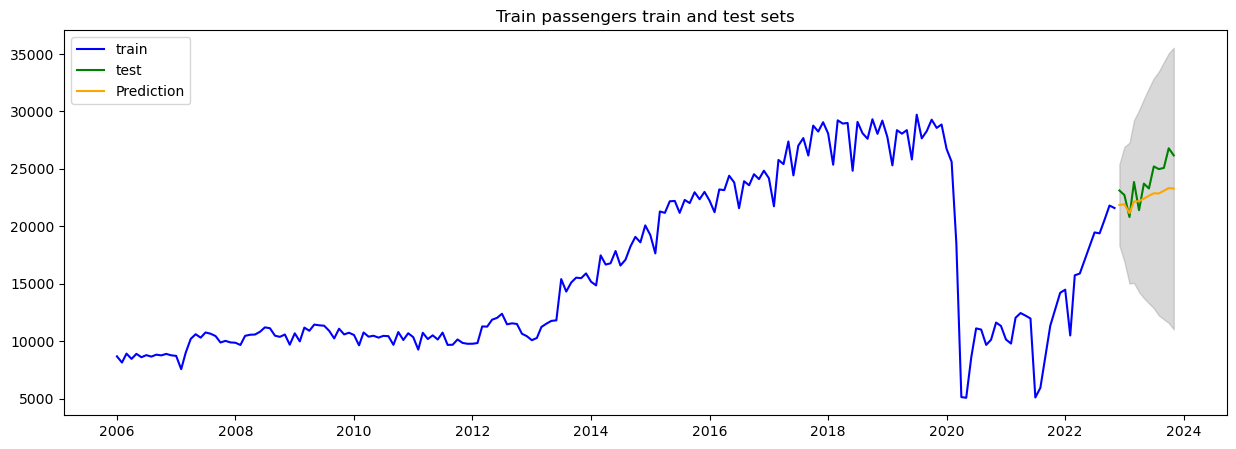

In [95]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_arima = pd.Series(prediction_arima,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.set_title("Train passengers train and test sets")
line1, = ax.plot(train.jabodetabek, color = "blue",label ="train")
line2, = ax.plot(test.jabodetabek, color = "green",label ="test")
line3, = ax.plot(prediction_arima, color = "orange",label ="Prediction")
ax.legend()
ax.legend(handles=[line1, line2, line3], loc ='upper left')
ax.fill_between(prediction_arima.index,
                cf_arima[0],
                cf_arima[1],color='grey',alpha=.3)

# Coba lakukan diffrencing dan variasi lag

In [79]:
model = pm.auto_arima(train.jabodetabek,
                       start_p=1, start_q=1,
                       test='adf',
                       max_p=3, max_q=3, m=12,
                       start_P=0, seasonal=True,
                       d=None, D=1, trace=True,
                       error_action='ignore',
                       suppress_warnings=True,
                       stepwise=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=3.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3478.320, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3447.346, Time=0.73 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=3470.687, Time=0.07 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=3435.199, Time=0.57 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.28 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=3430.720, Time=0.39 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=3449.632, Time=0.15 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=3398.268, Time=2.06 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=3.83 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=1

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  203
Model:             SARIMAX(0, 1, 3)x(2, 1, [1], 12)   Log Likelihood               -1690.914
Date:                              Sun, 14 Jan 2024   AIC                           3395.828
Time:                                      22:32:15   BIC                           3418.557
Sample:                                  01-01-2006   HQIC                          3405.035
                                       - 11-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1429      0.068      2.102      0.036       0.010       0.276
ma.L2         -0.0685      0.086     -0.797      0.426      -0.237       0.100
ma.L3         -0.1554      0.074     -2.095      0.036      -0.301      -0.010
ar.S.L12       0.1711      0.088      1.950      0.051      -0.001       0.343
ar.S.L24      -0.1884      0.084     -2.251      0.024      -0.352      -0.024
ma.S.L12      -0.8650      0.086    -10.087      0.000      -1.033      -0.697
sigma2      2.937e+06   2.69e+05     10.899      0.000    2.41e+06    3.47e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2609.76
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):              25.65   Skew:                            -2.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [80]:
# Forecast

prediction, confint = model.predict(n_periods=12, return_conf_int=True)

prediction

2022-12-01    22306.516993
2023-01-01    22031.667901
2023-02-01    19806.324257
2023-03-01    22074.789475
2023-04-01    20497.710841
2023-05-01    21271.636874
2023-06-01    21267.701147
2023-07-01    23391.838751
2023-08-01    23142.972616
2023-09-01    23020.566864
2023-10-01    23840.254721
2023-11-01    23436.817257
Freq: MS, dtype: float64

In [96]:
cf= pd.DataFrame(confint)


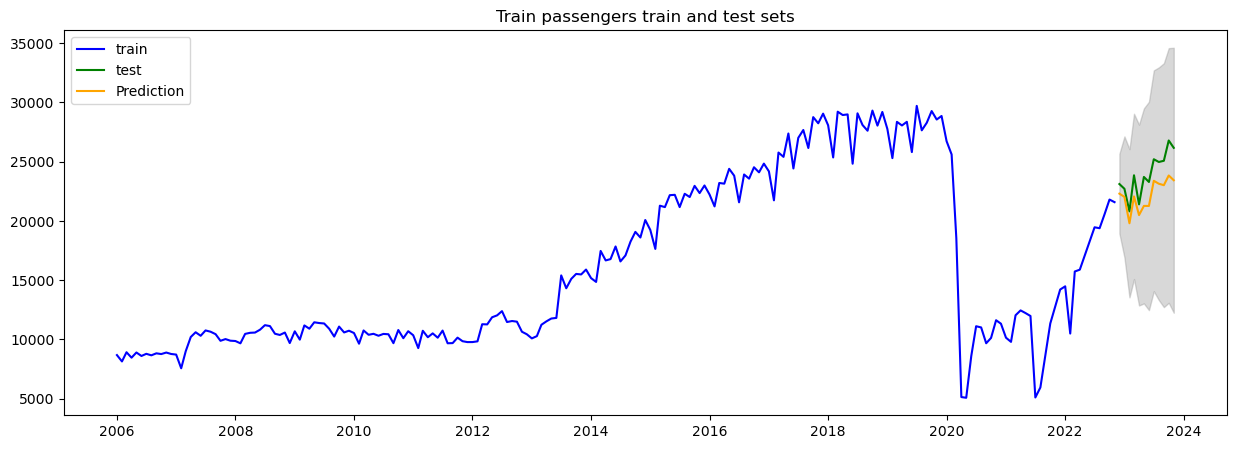

In [97]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.set_title("Train passengers train and test sets")
line1, = ax.plot(train.jabodetabek, color = "blue",label ="train")
line2, = ax.plot(test.jabodetabek, color = "green",label ="test")
line3, = ax.plot(prediction, color = "orange",label ="Prediction")
ax.legend()
ax.legend(handles=[line1, line2, line3], loc ='upper left')
ax.fill_between(prediction.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

In [84]:
rmse_seasonal_arima = np.sqrt(mse(test["jabodetabek"],prediction))
rmse_seasonal_arima

1900.1099880441234

# coba diffrencing denga diff max 2

In [85]:
sarimax_2 = pm.auto_arima(y = train["jabodetabek"],
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=2, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

sarimax_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,2,1)[12]             : AIC=inf, Time=3.99 sec
 ARIMA(0,1,0)(0,2,0)[12]             : AIC=3443.637, Time=0.13 sec
 ARIMA(1,1,0)(1,2,0)[12]             : AIC=3347.122, Time=1.21 sec
 ARIMA(0,1,1)(0,2,1)[12]             : AIC=inf, Time=1.38 sec
 ARIMA(1,1,0)(0,2,0)[12]             : AIC=3428.555, Time=0.14 sec
 ARIMA(1,1,0)(2,2,0)[12]             : AIC=3321.569, Time=2.28 sec
 ARIMA(1,1,0)(2,2,1)[12]             : AIC=inf, Time=2.65 sec
 ARIMA(1,1,0)(1,2,1)[12]             : AIC=inf, Time=1.23 sec
 ARIMA(0,1,0)(2,2,0)[12]             : AIC=3322.492, Time=0.61 sec
 ARIMA(2,1,0)(2,2,0)[12]             : AIC=3320.504, Time=2.98 sec
 ARIMA(2,1,0)(1,2,0)[12]             : AIC=3343.574, Time=1.46 sec
 ARIMA(2,1,0)(2,2,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(2,1,0)(1,2,1)[12]             : AIC=inf, Time=2.82 sec
 ARIMA(3,1,0)(2,2,0)[12]             : AIC=3321.197, Time=3.39 sec
 ARIMA(2,1,1)(2,2,0)[12]             : AIC=3321.2

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  203
Model:             SARIMAX(2, 1, 0)x(2, 2, 0, 12)   Log Likelihood               -1655.252
Date:                            Sun, 14 Jan 2024   AIC                           3320.504
Time:                                    22:33:39   BIC                           3336.413
Sample:                                01-01-2006   HQIC                          3326.955
                                     - 11-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1241      0.045      2.783      0.005       0.037       0.212
ar.L2         -0.1330      0.070     -1.907      0.056      -0.270       0.004
ar.S.L12      -0.9578      0.037    -25.757      0.000      -1.031      -0.885
ar.S.L24      -0.5883      0.077     -7.616      0.000      -0.740      -0.437
sigma2      6.961e+06   3.67e+05     18.976      0.000    6.24e+06    7.68e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               637.64
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):              30.10   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
# Forecast

prediction_2, confint_2 = sarimax_2.predict(n_periods=12, return_conf_int=True)

prediction_2


2022-12-01    22134.893360
2023-01-01    22753.157376
2023-02-01    19761.863639
2023-03-01    22569.898300
2023-04-01    20096.777455
2023-05-01    21068.337013
2023-06-01    24562.602831
2023-07-01    21760.601888
2023-08-01    23145.789102
2023-09-01    24624.144362
2023-10-01    26283.288814
2023-11-01    27276.469034
Freq: MS, dtype: float64

In [99]:
cf_2= pd.DataFrame(confint_2)

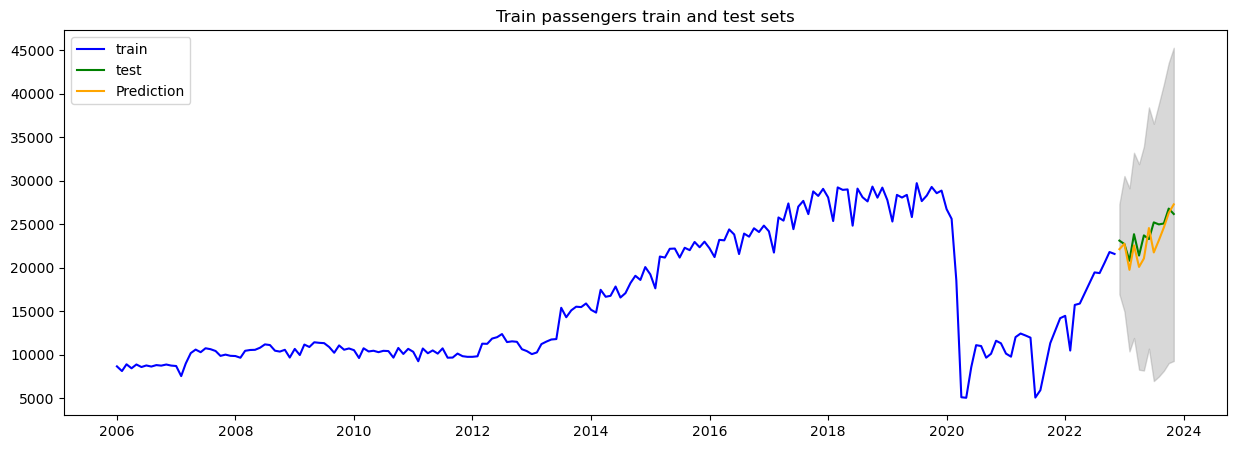

In [100]:
#Mostramos la gráfica con la predicción de los 2 últimos años en naranja
#sobre la serie real 
prediction_2 = pd.Series(prediction_2,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.set_title("Train passengers train and test sets")
line1, = ax.plot(train.jabodetabek, color = "blue",label ="train")
line2, = ax.plot(test.jabodetabek, color = "green",label ="test")
line3, = ax.plot(prediction_2, color = "orange",label ="Prediction")
ax.legend()
ax.legend(handles=[line1, line2, line3], loc ='upper left')
ax.fill_between(prediction_2.index,
                cf_2[0],
                cf_2[1],color='grey',alpha=.3)

In [89]:
rmse_seasonal_arima = np.sqrt(mse(test["jabodetabek"],prediction_log))
rmse_seasonal_arima

1607.4855063307132

# Prophet model

selanjutnya akan kita coba prophet model

In [90]:
train_prophet = train.reset_index().rename(columns={"date": "ds", "jabodetabek": "y"})
test_prophet = test.reset_index().rename(columns={"date": "ds", "jabodetabek": "y"})


In [91]:
# Create model objecct
m = Prophet()

# Fit model in data training
m.fit(train_prophet)

22:33:43 - cmdstanpy - INFO - Chain [1] start processing
22:33:43 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
forecast = m.predict(test_prophet)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-12-01,15893.695251,10603.574170,22305.662843,15893.695251,15893.695251,463.569076,463.569076,463.569076,463.569076,463.569076,463.569076,0.0,0.0,0.0,16357.264328
1,2023-01-01,15776.159096,10183.281554,21862.026432,15775.622156,15776.159096,48.589176,48.589176,48.589176,48.589176,48.589176,48.589176,0.0,0.0,0.0,15824.748272
2,2023-02-01,15658.622941,8908.214066,20169.151160,15654.761248,15662.797423,-1193.786236,-1193.786236,-1193.786236,-1193.786236,-1193.786236,-1193.786236,0.0,0.0,0.0,14464.836705
3,2023-03-01,15552.461253,10241.395735,22326.503125,15542.984799,15563.432521,261.140325,261.140325,261.140325,261.140325,261.140325,261.140325,0.0,0.0,0.0,15813.601578
4,2023-04-01,15434.925098,9082.330017,20761.337709,15419.021896,15457.019386,-369.925672,-369.925672,-369.925672,-369.925672,-369.925672,-369.925672,0.0,0.0,0.0,15064.999426


In [93]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
7,2023-07-01,15135.124473,9229.900197,20947.176420
8,2023-08-01,14812.650250,8699.840100,20932.296766
9,2023-09-01,14734.427608,9413.872012,20859.102552
10,2023-10-01,15438.311816,9868.184336,21698.978005
11,2023-11-01,15061.498233,9072.519724,20901.602326


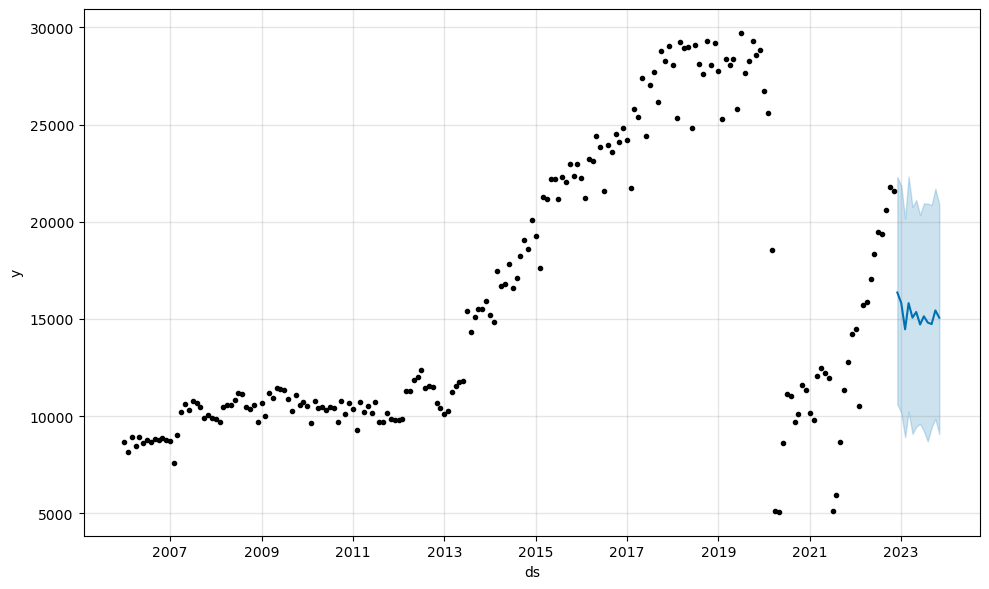

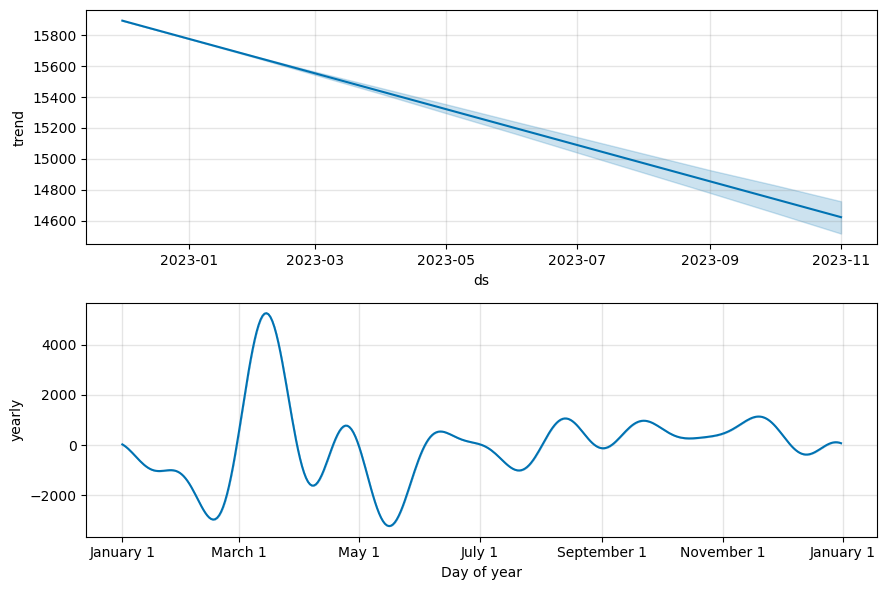

In [94]:
# Plot the forecast 
fig1 = m.plot(forecast)

# Plot the component of forecast
fig2 = m.plot_components(forecast)

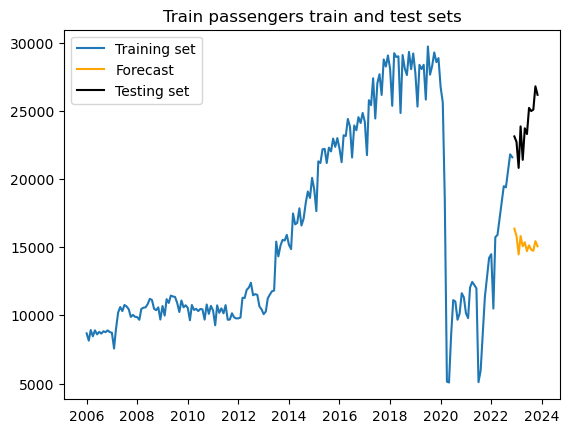

In [101]:
plt.title('Train passengers train and test sets')

plt.plot(train_prophet.set_index("ds")["y"], label='Training set')
plt.plot(forecast.set_index("ds")["yhat"], label='Forecast', color='orange')
plt.plot(test_prophet.set_index("ds")["y"], label='Testing set', color='k')
plt.legend();

In [102]:
rmse_prophet = np.sqrt(mse(test_prophet["y"],forecast.yhat))
rmse_prophet

8879.406444465792

# add regressor

In [103]:
m = Prophet()
m.add_regressor('covid')
m.fit(train_prophet)


22:37:59 - cmdstanpy - INFO - Chain [1] start processing
22:37:59 - cmdstanpy - INFO - Chain [1] done processing


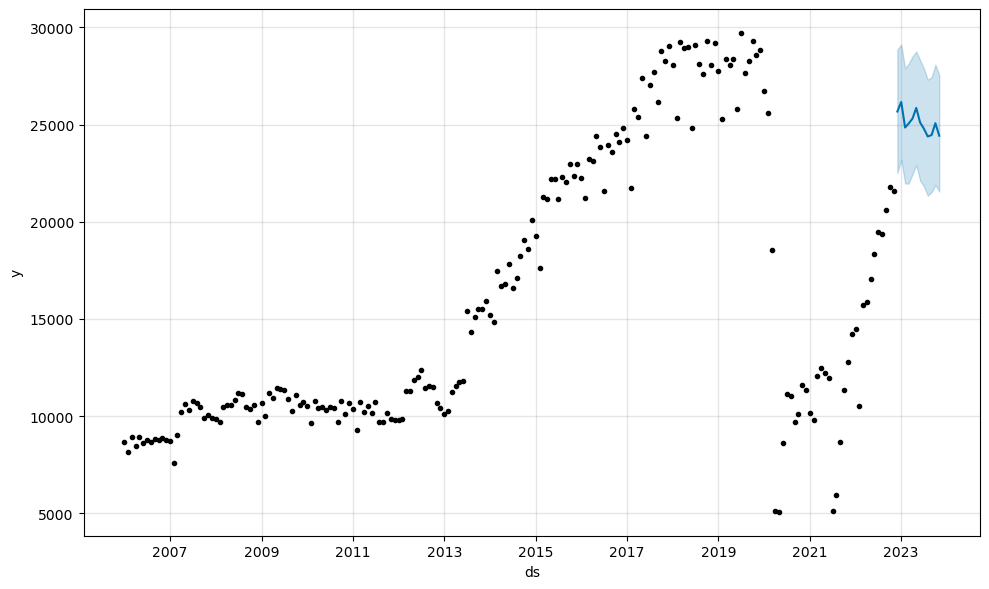

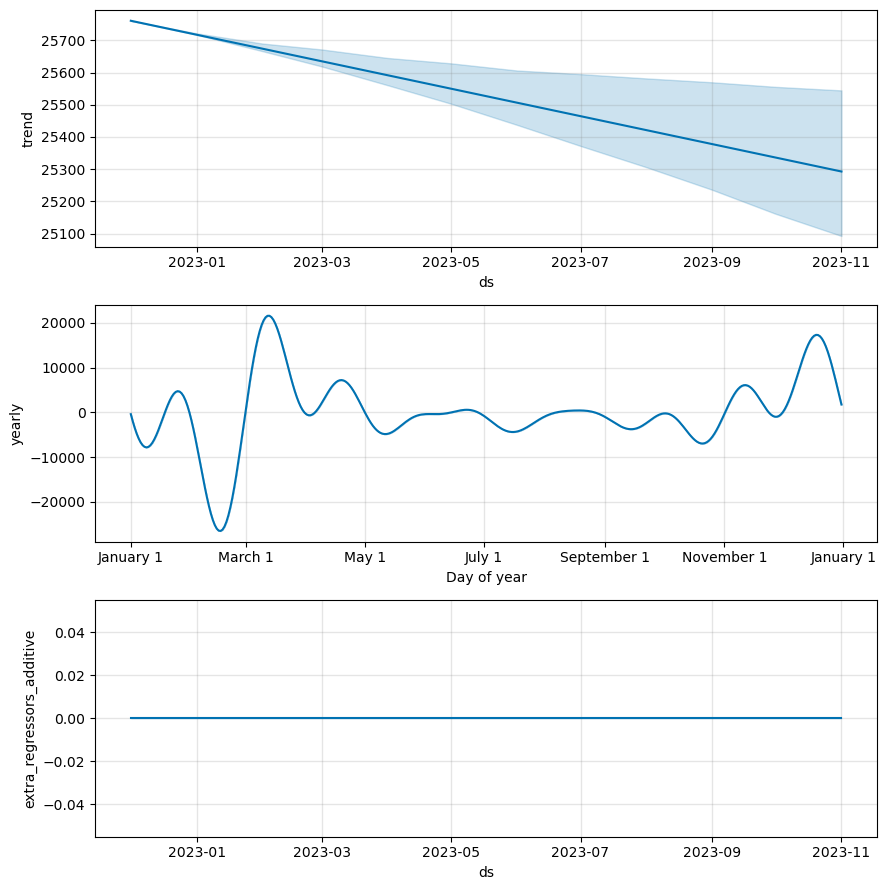

In [104]:
forecast = m.predict(test_prophet)

# Plot the forecast 
fig1 = m.plot(forecast)

# Plot the component of forecast
fig2 = m.plot_components(forecast)

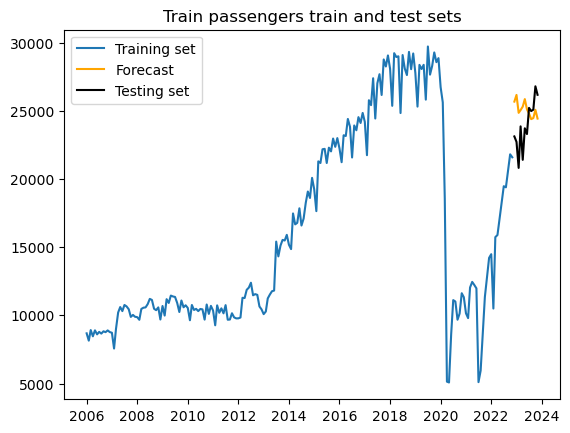

In [105]:
plt.title('Train passengers train and test sets')

plt.plot(train_prophet.set_index("ds")["y"], label='Training set')
plt.plot(forecast.set_index("ds")["yhat"], label='Forecast', color='orange')
plt.plot(test_prophet.set_index("ds")["y"], label='Testing set', color='k')
plt.legend();

In [106]:
rmse_prophet_regress = np.sqrt(mse(test_prophet["y"],forecast.yhat))
rmse_prophet_regress

2347.576767786298